In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Rock Paper Scissors Image Detection

#### Using transfer learning from a MobileNetV2 architecture trained on ImageNet.

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "images/"
train_dataset = image_dataset_from_directory(directory,
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.


Let's take a look at some of the images.

['paper', 'rock', 'scissors']


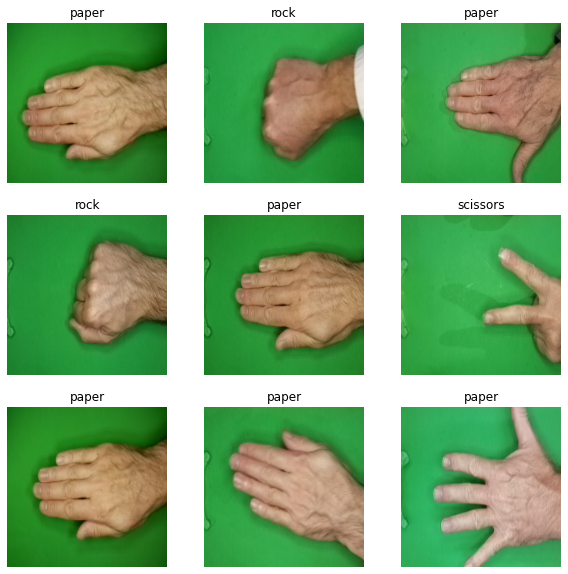

In [3]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.where(labels[i] == 1)[0][0]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

To make our training data even more robust on potential real-world use cases (and to showcase how easy it is to do in Tensorflow) we'll augment the data by doing some random flips and rotations.

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tfl.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

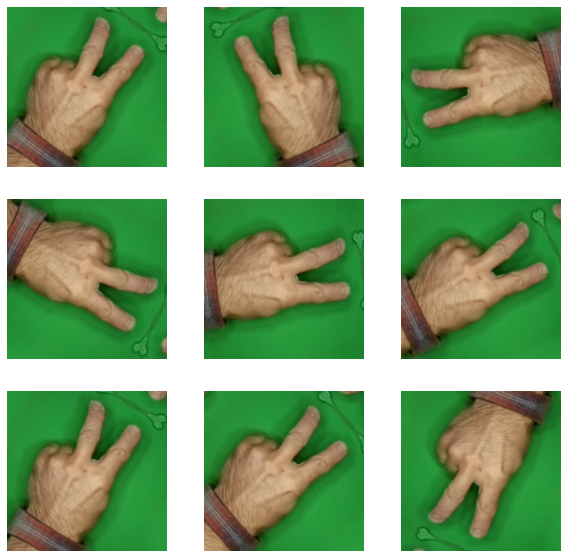

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Let's load the model and take a look at it's layers.

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Look at top layers responsible for categorizations.

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


Taking a look at some of the objects the base model has been configured to detect.

In [12]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n01930112', 'nematode', 0.0582284),
  ('n02088094', 'Afghan_hound', 0.027393866)],
 [('n04579432', 'whistle', 0.057447035),
  ('n04589890', 'window_screen', 0.038452867)],
 [('n03188531', 'diaper', 0.13062467),
  ('n01694178', 'African_chameleon', 0.067210935)],
 [('n02834397', 'bib', 0.16151741), ('n04579432', 'whistle', 0.040700965)],
 [('n04127249', 'safety_pin', 0.15753993),
  ('n04579432', 'whistle', 0.11862192)],
 [('n04026417', 'purse', 0.17012371), ('n03627232', 'knot', 0.10869367)],
 [('n04589890', 'window_screen', 0.15300378),
  ('n01930112', 'nematode', 0.035610814)],
 [('n02834397', 'bib', 0.060381427),
  ('n01740131', 'night_snake', 0.060372673)],
 [('n04332243', 'strainer', 0.17082594),
  ('n04589890', 'window_screen', 0.13403316)],
 [('n03124170', 'cowboy_hat', 0.47153124), ('n02834397', 'bib', 0.11821199)],
 [('n01930112', 'nematode', 0.2641867),
  ('n04127249', 'safety_pin', 0.09214103)],
 [('n04589890', 'window_screen', 0.6118372),
  ('n03347037', 'fire_screen', 0

There's a lot in there!  

Okay, now let's build our rock paper scissors model by changing the top layers of our base model and training those on our training dataset.

In [13]:
def rock_paper_scissors_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)

    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
    
    # add a dense layer before softmax
    x = tfl.Dense(3)(x)
    
    # create a prediction layer with softmax
    prediction_layer = tfl.Softmax()
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [14]:
model2 = rock_paper_scissors_model(IMG_SIZE, data_augmentation)

Below we'll compile and train the model.

In [15]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/Users/mattfergoda/.pyenv/versions/rock-paper-scissors/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
55/55 [==============================] - 15s 235ms/step - loss: 1.0215 - accuracy: 0.5003 - val_loss: 0.9333 - val_accuracy: 0.7185
Epoch 2/5
55/55 [==============================] - 13s 231ms/step - loss: 0.8939 - accuracy: 0.7190 - val_loss: 0.7950 - val_accuracy: 0.9474
Epoch 3/5
55/55 [==============================] - 14s 247ms/step - loss: 0.7879 - accuracy: 0.8715 - val_loss: 0.7198 - val_accuracy: 0.9611
Epoch 4/5
55/55 [==============================] - 13s 234ms/step - loss: 0.7295 - accuracy: 0.9126 - val_loss: 0.6789 - val_accuracy: 0.9634
Epoch 5/5
55/55 [==============================] - 14s 247ms/step - loss: 0.6898 - accuracy: 0.9440 - val_loss: 0.6566 - val_accuracy: 0.9657


After just 5 training epochs we're achieving near human-level performance!

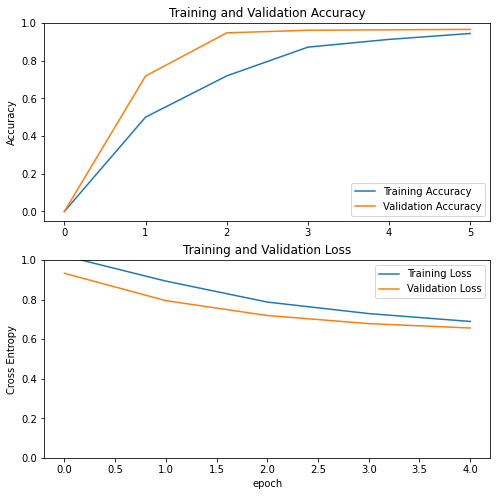

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can try and get to human-level performance by training the last 120 layers (of 154 total layers) of the model on the training data set. 

In [18]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


Let's see how it looks after 3 fine-tuning epochs.

In [19]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/8
55/55 [==============================] - 19s 298ms/step - loss: 0.6033 - accuracy: 0.9703 - val_loss: 0.5736 - val_accuracy: 0.9863
Epoch 6/8
55/55 [==============================] - 16s 298ms/step - loss: 0.5744 - accuracy: 0.9863 - val_loss: 0.5671 - val_accuracy: 0.9886
Epoch 7/8
55/55 [==============================] - 18s 320ms/step - loss: 0.5642 - accuracy: 0.9920 - val_loss: 0.5633 - val_accuracy: 0.9908
Epoch 8/8
55/55 [==============================] - 18s 327ms/step - loss: 0.5604 - accuracy: 0.9949 - val_loss: 0.5626 - val_accuracy: 0.9908


In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

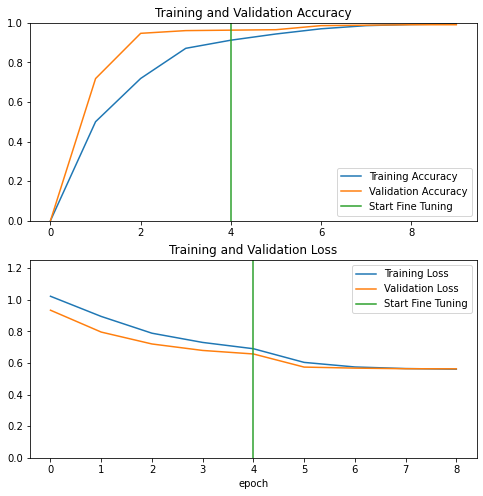

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.25])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We were able to achieve human-level performance with just 8 total training epochs of transfer learning! In the time it takes to run this notebook we now have a powerful model for detecting the classification of images in this data set.